[0.97196535 0.97196535 0.97196535 0.97196535 0.97196535 0.97196535
 0.97196535 0.97196535 0.97196535 0.97196535]
[ 1.  6. 11. 16. 21. 26. 31. 36. 41. 46.]


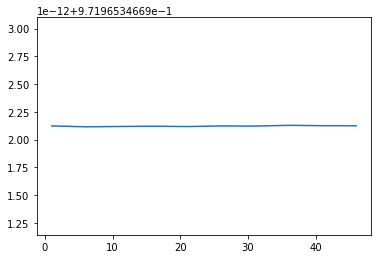

In [31]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import math

# ep0=6.25
# epinf=9.3
# wLO=213.3cm^(-1)
# just so i dont forget

l=0

# dielectric function
def dielec(r, me, mh, eps0, epsinf):
    rhoh=math.sqrt(1/(2*mh*0.0001545))
    rhoe=math.sqrt(1/(2*me*0.0001545))
    die=1/(1/eps0-(-1/epsinf+1/eps0)*(1-1/2*(2.7183**(-r/rhoh)+2.7183**(-r/rhoe))))
    return die

# main function body
def qd(mdot, mlig, Vdot, Vlig, L, Lout, s):
    # discretizing length we look at and defining mass, potential, position functs
    h=(L+Lout)/s

    k=int(L/h)
    
    mvec=np.zeros(s)
    for i in range (0,k):
        mvec[i]=mvec[i]+mdot
    for i in range (k,s):
        mvec[i]=mvec[i]+mlig
        
    Vvec=np.zeros(s)
    for i in range (0,k):
        Vvec[i]=Vvec[i]+Vdot
    for i in range (k,s):
        Vvec[i]=Vvec[i]+Vlig

    xlis=[]
    for i in range(1, s+1):
        xlis.append(i*h)
    x=np.array(xlis)

    Uvec=np.zeros(s)+Vvec+1/(2*mvec)*l*(l+1)/(x*x)
    
    # eps and deps from UT dallas, used some runge kutta
    eps=np.zeros(s)
    for i in range(0,s):
        if i==0:
            continue
        eps[i]=1/(4*h*h)*(1/mvec[i-1]+1/mvec[i])
    eps[0]=eps[1]

    deps=np.zeros(s)
    for i in range (0,s):
        if i==0 or i==s-1:
            continue
        deps[i]=1/(4*h*h)*(1/mvec[i-1]+2/mvec[i]+1/mvec[i+1])+Uvec[i]
    deps[0]=deps[1]
    deps[s-1]=deps[s-2]

    # hamiltonian matrix, a little wonky, might rework better using np.zeros
    hamlist1=[]

    for i in range(1, s+1):
        if i==1:
            hamlist1.append(deps[0])
        elif i==2:
            hamlist1.append(-eps[1])
        else:
            hamlist1.append(0)

    ham=np.array(hamlist1)
    ham=np.array([ham])

    for i in range(2, s+1):
        hami=np.array([])
        for j in range (1, s+1):
            if i==j:
                hami=np.append(hami,deps[i-1])
            elif j==i-1:
                hami=np.append(hami,-eps[i-1])
            elif j==i+1:
                hami=np.append(hami,-eps[i])
            else:
                hami=np.append(hami, 0)
        hami=np.array([hami])
        ham=np.append(ham, hami, axis=0)

    # solving for psi and energies (eigenvectors and eigenvalues, praise linalg)
    results=la.eigh(ham)

    # normalizing in 3D spherical symmetry
    PsiNorm=results[1][:,0]/x*1/(2*math.sqrt(math.pi))
    PsiNorm=PsiNorm/(math.sqrt(h*np.sum(PsiNorm*PsiNorm*x*x)*4*math.pi))
    
    # probability density
    ProbDens=PsiNorm*PsiNorm*4*x*x*math.pi
    
    # first part of coulomb integral, psi/Y used instead of psi
    IntF=np.zeros(s)
    for i in range(0,s):
        IntSum=np.zeros(i)
        for j in range(0,i):
            IntSum[j]=IntSum[j]+x[j]*PsiNorm[j]*x[j]*PsiNorm[j]*h*4*math.pi
        IntF[i]=np.sum(IntSum)
    
    #plt.plot(x, ProbDens)
    #plt.plot(x, PsiNorm*PsiNorm*4*math.pi)
    #plt.plot(x, IntF)
    
    xmax=np.where(ProbDens==np.amax(ProbDens))
    rsr=x[xmax][0]
    
    list=[]
    list.append(PsiNorm)
    list.append(rsr)
    list.append(IntF)
    list.append(x)
    list.append(results[0][0])
    
    return list
    
#e=qd(0.13, 1, -0.1507, -0.03675, 37.79, 18.9*0, 100)
#h=qd(0.45, 1, +0.2131, +0.305, 37.79, 18.9*0, 100)

#dielectric=dielec(abs(e[1]-h[1]), 0.13, 0.45, 6.25, 9.3)
#print(dielectric)

dielectric=6.25

# second part of coulomb integral, psi/Y used instead of psi
#IntZ=np.zeros(100)
#for i in range (0,100):
    #IntZ[i]=IntZ[i]+e[3][i]/(dielectric)*(e[2][i]*(h[0][i]*h[0][i])*4*math.pi+h[2][i]*(e[0][i]*e[0][i])*4*math.pi)*37.79/100
#Eeh=np.sum(IntZ)
#print(Eeh/(1.786/(dielectric*37.79)))
#print(Eeh)

unit=np.zeros(10)
for i in range(0,10):
    IntZ=np.zeros(100)
    e=qd(0.13, 1, -0.1507, -0.03675, 1+i*5, 0, 100)
    h=qd(0.45, 1, +0.2131, +0.305, 1+i*5, 0, 100)
    for j in range (0,100):
        IntZ[j]=IntZ[j]+e[3][j]/(dielectric)*(e[2][j]*(h[0][j]*h[0][j])*4*math.pi+h[2][j]*(e[0][j]*e[0][j])*4*math.pi)*(1+i*5)/100
    Eeh=np.sum(IntZ)
    unit[i]=Eeh/(1.786/(dielectric*(1+i*5)))
    
unitx=np.zeros(10)
for i in range(0,10):
    unitx[i]=1+i*5

print(unit)
print(unitx)
plt.plot(unitx, unit)

# Simulation matches BRUS equation perfectly: correct solution for spherical infinite well!